# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 24.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


Download the dataset

In [2]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1020868 [00:00<?, ? examples/s]

In [3]:
ds

Dataset({
    features: ['source', 'term', 'quantifier_frequency', 'quantifier_number', 'generic_sentence', 'score'],
    num_rows: 1020868
})

Filter row with length greater than 8.


In [4]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)

Filter:   0%|          | 0/1020868 [00:00<?, ? examples/s]

Create a tokenizer and Detokenizer

In [5]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s="<start>"
          elif t == 2:
            s="<end>"
          elif t == 7:
            s="<comma>"
          else:
            s=self.index_to_word.get(t, '[UNK]')
          return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]



detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()


Remove from corpus the sentences where any unknow word appears

In [6]:
mask = np.sum( (sentences==1) , axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [7]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [8]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])

        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return data_batch , result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)
            np.random.shuffle(self.indexes)

In [9]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [10]:
#split the dataset
train_generator = DataGenerator(shuffled_data[:220000])
test_generator = DataGenerator(shuffled_data[220000:])

In [11]:
x, y = test_generator.__getitem__(1)
x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
  print("original: ", y[i])
  print("shuffled: ", x[i])
  print("\n")

original:  <start> many species dive or swim underwater to capture their prey <end>
shuffled:  <start> many underwater dive or swim species prey their to capture <end>


original:  <start> nature is made up of both body and soul <end>
shuffled:  <start> body is of soul both made up and nature <end>


original:  <start> smokers call in sick about two more days a year than nonsmokers <end>
shuffled:  <start> call more in smokers sick days year about nonsmokers than two a <end>


original:  <start> atheists gather early in the morning on the snowy meadows <end>
shuffled:  <start> the early morning the snowy in meadows atheists on gather <end>


original:  <start> different individuals seem to be able to absorb different forms of calcium and magnesium <end>
shuffled:  <start> different be forms absorb able magnesium and individuals seem to calcium different to of <end>


original:  <start> monarchs are unique because they migrate each winter to avoid freezing weather <end>
shuffled:  <star

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [12]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/max(len(p),len(s)))

Let's do an example.

In [13]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

# Start

## Dataset modification

#### Create target data for teacher forcing method
compared to original_data, the samples in target_data are shifted by one bit to right. However, to avoid changing the dimensions, target_data is padded by zeros.

In [14]:
target_data = np.array([s[1:] for s in original_data])
target_data = np.pad(target_data, ((0, 0), (0, 1)), mode='constant')

#### Modifying the data generator
The NewDataGenerator produces the output as "(*data_batch*, *result*), *target_batch* ", where *data_batch* is batch of shuffled data, *target_batch* is the batch of shuffled *target_data* related to *data_batch*. The *result* is the related unshuffled data.

In [15]:
class NewDataGenerator(DataGenerator) :
    """
    Added this class for teacher forcing method
    """
    def __init__(self, target_data, *args, **kwargs) :
        super(NewDataGenerator, self).__init__(*args, **kwargs)
        self.target_data = target_data

    def __getitem__(self, index) :
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        target_batch = np.array([self.target_data[k] for k in indexes])

        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return (data_batch, result) , target_batch

creating *shuffled_target_data* from *shuffled_indices* which was previously produced.

In [16]:
shuffled_target_data = target_data[shuffled_indices]

We are going to model the transformer structure according to the [offical tensorflow website](https://www.tensorflow.org/text/tutorials/transformer#training_and_checkpointing)<br>
The structure is using the teacher forcing technique, which is implemented according to these pages on [stackoverflow](https://stackoverflow.com/questions/57099613/how-is-teacher-forcing-implemented-for-the-transformer-training#:~:text=Each%20train_step%20takes%20in%20inp%20and%20tar%20objects%20from%20the%20dataset%20in%20the%20training%20loop.%20Teacher%20forcing%20is%20indeed) and [github](https://github.com/tensorflow/tensorflow/issues/30852#:~:text=Each%20train_step%20takes)

In [17]:
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization, Add
from keras.callbacks import EarlyStopping #,ModelCheckpoint
# from transformers import DistilBertTokenizerFast #, TFDistilBertModel
# from transformers import TFDistilBertForTokenClassification
from tqdm import tqdm_notebook as tqdm

#### Positional Encoding

In [18]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

#### Positional Embedding
Note: The original paper, section 3.4 and 5.1, uses a single tokenizer and weight matrix for both the source and target languages. This tutorial uses two separate tokenizers and weight matrices.

In [19]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, embedder, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = embedder
        self.pos_encoding = positional_encoding(length=28, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[tf.newaxis, :length, :]
        return x

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a layers.MultiHeadAttention, a layers.LayerNormalization and a layers.Add.

In [54]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(**kwargs)
    self.layernorm = LayerNormalization(epsilon=1e-7)  # The default epsilon=1e-3 causes some problems for evaluating and fitting the model withing the GPU
    self.add = Add()

#### The cross attention layer

In [21]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

#### The glabal self attention layer

In [22]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

#### The causal self attention layer

In [23]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True
        )
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

#### The feed forward layer

In [24]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-7)

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

#### The Encoder layer

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

#### The Encoder

In [26]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, embedder, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = embedder

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

#### The Decoder layer

In [27]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # The last attention scores are cached for later plotting
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

#### The Decoder

In [28]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, embedder, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(embedder, vocab_size=vocab_size, d_model=d_model)

    self.dropout = Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

#### The Transformer

In [29]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.embedder = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)
    # self.embedder = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=False)
    self.encoder = Encoder(self.embedder,num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)
    self.decoder = Decoder(self.embedder,num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # All inputs must be passed in the first argument to use '.fit'
    context, x  = inputs
    context = self.encoder(context)  # (batch_size, context_len, d_model)
    x = self.decoder(x, context)  # (batch_size, target_len, d_model)
    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Keras mask is dropped, so it doesn't scale with losses or metrics.
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

## Training

#### Defining the transformer model alongside the hyperparameters

In [30]:
def get_transformer(num_layers=4, d_model=128, dff=512, num_heads=8, dropout_rate = 0.1) :
    input_vocab_size = tokenizer.vocabulary_size()
    target_vocab_size = tokenizer.vocabulary_size()

    transformer = Transformer(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        input_vocab_size=input_vocab_size,
        target_vocab_size=target_vocab_size,
        dropout_rate=dropout_rate
    )
    return transformer

#### Set up optimizer

In [31]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

#### Custom accuracy function

In [32]:
def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

#### Custom loss function

In [55]:
K_VALUE = 0.97
max_sequence_len = 28 # maximum length of sequences in our data

# Defining a custom loss function that works directly on tokens
def custom_masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    a = tf.cast(tf.range(1,max_sequence_len+1),tf.float32)
    constant_val = tf.constant(K_VALUE)
    final_array = tf.pow(constant_val,a)

    mask = tf.cast(mask, dtype=loss.dtype)
    mask*=final_array

    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

## Training the Transformer

4th attempt

In [34]:
batch_size = 512
hyperparameters = {"num_layers":4, "d_model":180, "dff":512, "num_heads":8, "dropout_rate":0.2}

In [35]:
cutting_point = 220000
remaining_samples = shuffled_data.shape[0] - cutting_point
val_point = cutting_point + int(remaining_samples/2)  # 50/50 validation and test

new_train_generator = NewDataGenerator(data=shuffled_data[:cutting_point], target_data=shuffled_target_data[:cutting_point], batch_size=batch_size)
validation_generator = NewDataGenerator(data=shuffled_data[cutting_point:val_point], target_data=shuffled_target_data[cutting_point:val_point], batch_size=batch_size)
new_test_generator = NewDataGenerator(data=shuffled_data[val_point:], target_data=shuffled_target_data[val_point:], batch_size=batch_size)

In [36]:
transformer2 = get_transformer(**hyperparameters)


learning_rate = CustomSchedule(hyperparameters["d_model"])

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9,
    beta_2=0.98, epsilon=1e-9
    )

In [37]:
transformer2.compile(
    loss=custom_masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy]
    )

In [38]:
transformer2.build(input_shape=[(None, max_sequence_len), (None, max_sequence_len)])
transformer2.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1800000   
                                                                 
 encoder (Encoder)           multiple                  6708128   
                                                                 
 decoder (Decoder)           multiple                  10874768  
                                                                 
 dense_16 (Dense)            multiple                  1810000   
                                                                 
Total params: 17592896 (67.11 MB)
Trainable params: 17592896 (67.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
es = EarlyStopping(monitor='val_masked_accuracy', mode='max', verbose=1, patience=2)

max_epochs = 100

history = transformer2.fit(
    new_train_generator,
    epochs=max_epochs,
    callbacks = [es],
    validation_data = validation_generator
)

Epoch 1/100
429/429 [==============================] - 240s 487ms/step - loss: 7.7622 - masked_accuracy: 0.1424 - val_loss: 6.1784 - val_masked_accuracy: 0.2592
Epoch 2/100
429/429 [==============================] - 206s 481ms/step - loss: 5.1290 - masked_accuracy: 0.3449 - val_loss: 4.0992 - val_masked_accuracy: 0.4411
Epoch 3/100
429/429 [==============================] - 207s 482ms/step - loss: 3.4752 - masked_accuracy: 0.4977 - val_loss: 2.6024 - val_masked_accuracy: 0.5939
Epoch 4/100
429/429 [==============================] - 207s 482ms/step - loss: 2.2946 - masked_accuracy: 0.6160 - val_loss: 1.6699 - val_masked_accuracy: 0.6948
Epoch 5/100
429/429 [==============================] - 207s 483ms/step - loss: 1.6213 - masked_accuracy: 0.6838 - val_loss: 1.1900 - val_masked_accuracy: 0.7472
Epoch 6/100
429/429 [==============================] - 207s 483ms/step - loss: 1.2794 - masked_accuracy: 0.7205 - val_loss: 1.0786 - val_masked_accuracy: 0.7583
Epoch 7/100
429/429 [=============

saving the model

In [41]:
transformer2.save_weights("/content/drive/MyDrive/DeepLraning-Unibo/model_weights/tf2/weights/transformer2")

saving the training history as a csv file

In [42]:
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'history_transformer2.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

#### Plotting the loss and accuracy measures

total steps:  15360
total epochs:  30


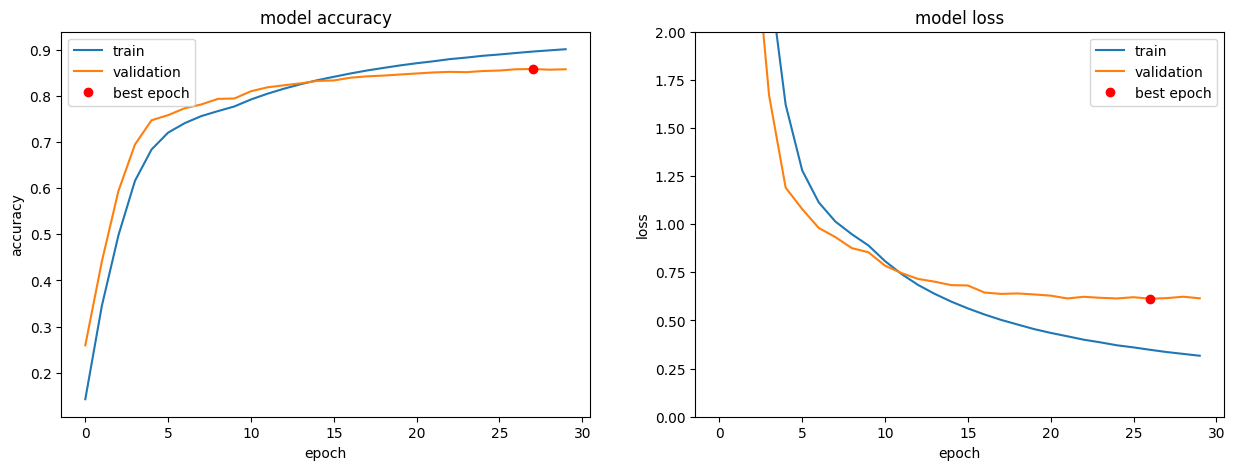

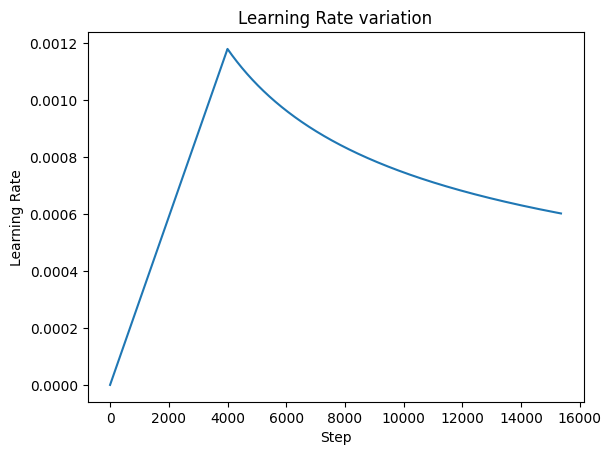

In [57]:
import matplotlib.pyplot as plt

def plot_loss_validatio(history, batch_size) :
    #print number of steps and epochs done
    print("total steps: ", len(history.history["loss"])*batch_size)
    print("total epochs: ", len(history.history["loss"]))
    #plot accuracy
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['masked_accuracy'], label="train")
    plt.plot(history.history['val_masked_accuracy'], label="validation")
    #draw a red point at the best epoch for validation accuracy
    best_epoch=np.argmax(history.history['val_masked_accuracy'])
    plt.plot(best_epoch,history.history['val_masked_accuracy'][best_epoch],'ro', label="best epoch")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    #plot loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="train")
    plt.plot(history.history['val_loss'], label="validation")
    #draw a red point at the best epoch for validation loss
    best_epoch=np.argmin(history.history['val_loss'])
    plt.plot(best_epoch,history.history['val_loss'][best_epoch],'ro', label="best epoch")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.ylim([0, 2])  # Set y-axis limits to [0, 2]
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    #plot learning rate
    learning_rates = [learning_rate(step).numpy() for step in range(len(history.history['loss'])*batch_size)]
    plt.plot(np.arange(len(learning_rates)), learning_rates)
    plt.title("Learning Rate variation")
    plt.xlabel("Step")
    plt.ylabel("Learning Rate")
    plt.show()

plot_loss_validatio(history, 512)

## Load the model

In [40]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
transformer2.load_weights("/content/drive/MyDrive/DeepLraning-Unibo/model_weights/tf2/weights/transformer2")

## Evaluation (based on the *score* function)

In [53]:
print(f'number of batches in test generator = {len(new_test_generator)}')
print(f'number of samples in one batch = {new_test_generator.batch_size}')
print(f'number of samples = {len(new_test_generator)*new_test_generator.batch_size}')
print(f'number of needed batches for 3k samples is approimately = {int(3000/new_test_generator.batch_size)+1}')

number of batches in test generator = 20
number of samples in one batch = 512
number of samples = 10240
number of needed batches for 3k samples is approimately = 6


In [58]:
def translator(model, shuffled_sentences, batch_size=512, max_sequence_len=max_sequence_len) :
    encoder_input = shuffled_sentences

    # word index for '<start>' is 3
    decoded_indexes = [[3] for _ in range(batch_size)]

    # 3 --> start, 2 --> end, 0 for paddings
    allowed_words = [ [word for word in sentence if word not in [3, 2, 0]] for sentence in encoder_input]

    for i in range(1, max_sequence_len):
        decoder_input = tf.convert_to_tensor(decoded_indexes)

        predictions = np.array(model((np.array(encoder_input), np.array(decoder_input))))
        predictions = predictions[:, -1, :]

        for j in range(batch_size):

            # if there are no more allowed words for a specific sentence, concatenate the eos token
            if len(allowed_words[j]) == 0:
                best_token = 2 # end of the sentence
            else:
                filtered_predictions = predictions[j, np.array(allowed_words[j])]
                best_index = np.argmax(filtered_predictions)
                best_token = allowed_words[j][best_index]

                del allowed_words[j][best_index]
            decoded_indexes[j].append(best_token)
    return decoded_indexes

In [46]:
def process(sentence):
    return sentence.replace('<start>', '').replace('<pad>', '').replace('<end>', '').strip()

In [52]:
batch_size = 512
total_samples = 3000

total_batches = int(total_samples/batch_size)+1

sc = 0
for i in range(total_batches) : # it's better to choose random batches
    (shuffled_sentences, _) , original_sentences = new_test_generator[i]

    translated = translator(transformer2, shuffled_sentences)
    for j in range(batch_size):
        single_shuffled = process(detokenizer([shuffled_sentences[j]])[0])

        single_translated = detokenizer([translated[j]])[0]
        single_translated = single_translated.split("<end>")[0]
        single_translated = process(single_translated)

        single_original = process(detokenizer([original_sentences[j]])[0])

        # updating the score
        sc = sc + score(single_original, single_translated)
    print(f"Computed: {i+1}; Score: {sc/((i+1)*batch_size)}")

sc = sc/(total_batches*batch_size)
print("Total score:", sc)

Computed: 1; Score: 0.5566451688789974
Computed: 2; Score: 0.5416612091044933
Computed: 3; Score: 0.5485883389138493
Computed: 4; Score: 0.5458627748071679
Computed: 5; Score: 0.5522369923646971
Computed: 6; Score: 0.5552044218408697
Total score: 0.5552044218408697
